## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2, l1_l2
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128, 64], regularizer=None, drp_ratio=None, batch_normalization=None):
    """
    Build your own model
    """
    if regularizer:
        regularizer = regularization()
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1), kernel_regularizer=regularizer)(input_layer)
            if batch_normalization:
                x = keras.layers.BatchNormalization()(x)
            if drp_ratio:
                x = keras.layers.Dropout(drp_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1), kernel_regularizer=regularizer)(x)
            if batch_normalization:
                x = keras.layers.BatchNormalization()(x)
            if drp_ratio:
                x = keras.layers.Dropout(drp_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-2
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
regularizer = [None, keras.regularizers.l1, keras.regularizers.l2]
drp_ratio = [0, 0.2]
batch_normalization = [None, True]

In [7]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for reg in regularizer:
    for drp in drp_ratio:
        for bn in batch_normalization:
            
            keras.backend.clear_session() # 把舊的 Graph 清掉
            if reg:
                reg_name = reg.__name__
            else:
                reg_name = 'None'
            print('Experiment with regularization ={}, dropout={}, batch_normalization={}'.format(reg_name, str(drp), str(bn)))
            model = build_mlp(input_shape=x_train.shape[1:], regularizer=reg, drp_ratio=drp, batch_normalization=bn)
            model.summary()
            optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
            model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

            model.fit(x_train, y_train, 
                      epochs=EPOCHS, 
                      batch_size=BATCH_SIZE, 
                      validation_data=(x_test, y_test), 
                      shuffle=True)

            # Collect results
            train_loss = model.history.history["loss"]
            valid_loss = model.history.history["val_loss"]
            train_acc = model.history.history["acc"]
            valid_acc = model.history.history["val_acc"]

            exp_name_tag = "reg={},dropout={},batch_norm={}".format(reg_name, str(drp), str(bn))
            results[exp_name_tag] = {'train-loss': train_loss,
                                     'valid-loss': valid_loss,
                                     'train-acc': train_acc,
                                     'valid-acc': valid_acc}

W0804 15:39:34.410971 4657214912 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0804 15:39:34.414005 4657214912 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0804 15:39:34.458939 4657214912 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0804 15:39:34.460041 4657214912 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0804 15:39:34.464555 46

Experiment with regularization =None, dropout=0, batch_normalization=None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
hidden_layer4 (Dense)        (None, 64)                8256      
_________________________________________________________________
output (Dense)               (None, 10)                650       
Total params: 1,746,506
Trainable params: 1,746,506
Non-trainable pa

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

50000/50000 [==============================] - 6s 114us/step - loss: 0.2866 - acc: 0.8965 - val_loss: 2.7505 - val_acc: 0.4819
Epoch 48/50
50000/50000 [==============================] - 6s 114us/step - loss: 0.2799 - acc: 0.8998 - val_loss: 2.8613 - val_acc: 0.4696
Epoch 49/50
50000/50000 [==============================] - 6s 114us/step - loss: 0.2542 - acc: 0.9090 - val_loss: 2.7438 - val_acc: 0.4861
Epoch 50/50
50000/50000 [==============================] - 6s 113us/step - loss: 0.2546 - acc: 0.9088 - val_loss: 2.8759 - val_acc: 0.4741


W0804 15:50:00.620115 4657214912 deprecation.py:506] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Experiment with regularization =None, dropout=0.2, batch_normalization=None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________


50000/50000 [==============================] - 6s 128us/step - loss: 1.2747 - acc: 0.5450 - val_loss: 1.3352 - val_acc: 0.5226
Epoch 48/50
50000/50000 [==============================] - 7s 141us/step - loss: 1.2769 - acc: 0.5457 - val_loss: 1.3323 - val_acc: 0.5246
Epoch 49/50
50000/50000 [==============================] - 8s 159us/step - loss: 1.2703 - acc: 0.5465 - val_loss: 1.3039 - val_acc: 0.5337
Epoch 50/50
50000/50000 [==============================] - 7s 138us/step - loss: 1.2591 - acc: 0.5515 - val_loss: 1.3107 - val_acc: 0.5313
Experiment with regularization =None, dropout=0.2, batch_normalization=True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
__________________________________________________

50000/50000 [==============================] - 7s 131us/step - loss: 1.2365 - acc: 0.5599 - val_loss: 1.3311 - val_acc: 0.5290
Epoch 40/50
50000/50000 [==============================] - 7s 132us/step - loss: 1.2316 - acc: 0.5601 - val_loss: 1.3141 - val_acc: 0.5357
Epoch 41/50
50000/50000 [==============================] - 7s 132us/step - loss: 1.2247 - acc: 0.5650 - val_loss: 1.3257 - val_acc: 0.5293
Epoch 42/50
50000/50000 [==============================] - 7s 132us/step - loss: 1.2279 - acc: 0.5596 - val_loss: 1.4080 - val_acc: 0.5028
Epoch 43/50
50000/50000 [==============================] - 7s 130us/step - loss: 1.2194 - acc: 0.5657 - val_loss: 1.3337 - val_acc: 0.5241
Epoch 44/50
50000/50000 [==============================] - 7s 131us/step - loss: 1.2201 - acc: 0.5647 - val_loss: 1.3735 - val_acc: 0.5092
Epoch 45/50
50000/50000 [==============================] - 7s 135us/step - loss: 1.2125 - acc: 0.5690 - val_loss: 1.3159 - val_acc: 0.5338
Epoch 46/50
50000/50000 [==============

NameError: name 'regularization' is not defined

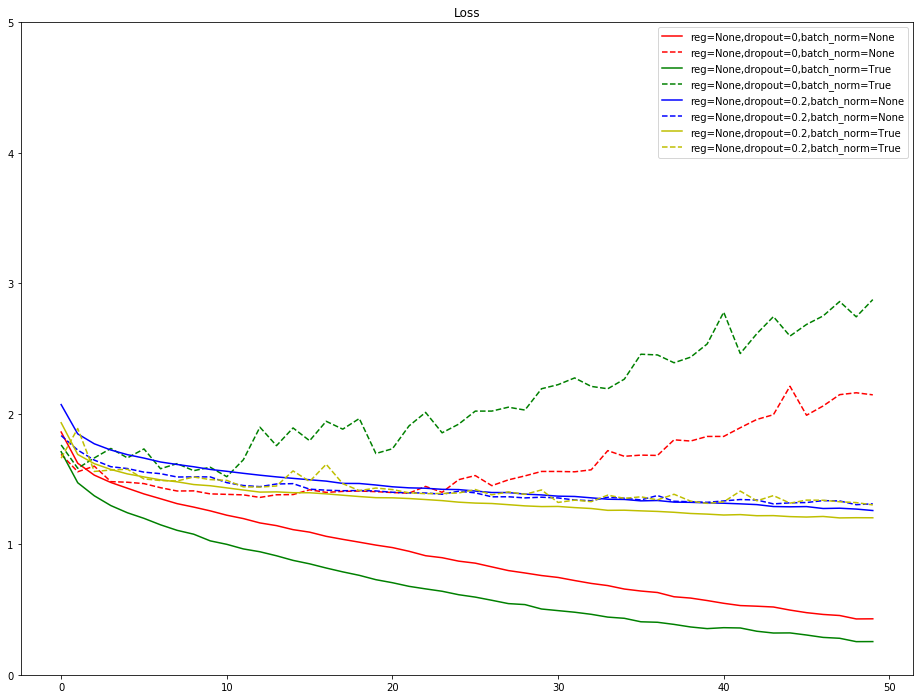

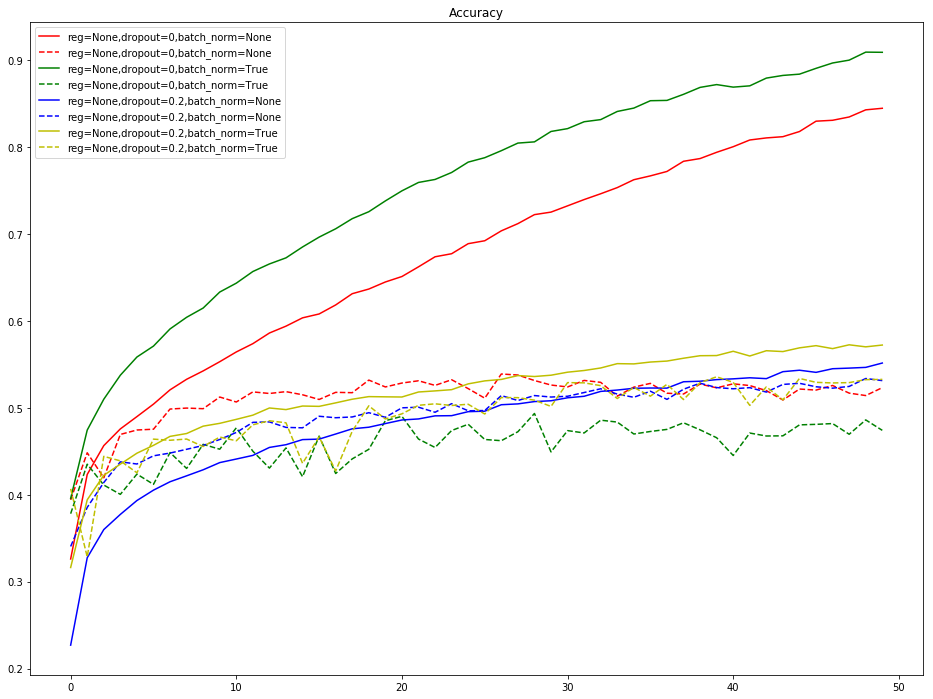

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k", "orange", "purple", "crimson", "indigo", "magenta", "sienna"]

plt.figure(figsize=(16,12))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(16,12))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()